# Introduction

We want our model to estimate election outcomes based on the fundamentals and poll data. Thus, we need a "poll feature" for each district upon which to train. Unfortunately, many districts do not have poll data. We overcome this by interpolating poll results for districts that do not have polls from districts that do have polls based on districts' similarity in demographics and historical election results.

The poll data points upon which we will interpolate are [538](https://fivethirtyeight.com/features/2018-house-forecast-methodology/)'s adjusted poll margins. We will pull the most recent adjusted margin (MRAM).

We perform the interpolation using [radial basis function interpolation](http://num.math.uni-goettingen.de/schaback/teaching/sc.pdf) (RBF interpolation).

In [1]:
print('starting')

import pandas as pd
import numpy as np
import scipy.cluster
import scipy.interpolate
from scipy import stats
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
import matplotlib.pyplot as plt
plt.style.use('ggplot')

print('done')

starting
done


# Input Data

We will now interpolate real polls based on a large range of input features. We predict based on ProximityOne's [demographic data by congressional district](http://proximityone.com/cd.htm). Specifically, we input a hand-selected set of [social characteristics](http://proximityone.com/cd161dp2.htm).

In [2]:
print('starting')

pp = pd.read_csv('ppoll_n.csv', header=None)
df = pd.read_excel('handmod.xlsx', sheet='Sheet 1', header=None)

ins = ['S' + str(rep).zfill(3) for rep in range(df.shape[1])]
outs = ['MRAM']

# Drop rows that have non-numerical data
df.dropna(inplace=True)
df = df[df.applymap(np.isreal).any(1)]
df.columns = ins
df['MRAM'] = pp.iloc[:,1]

# Make a copy of all the data before you drop the districts without polls
raw = df.copy(deep=True)

# Drop rows that down have MRAM
df = df[df['MRAM'] != 0]

print('done')

starting
done


# Preprocessing

We obviously must drop all non-numeric data. However, we also must drop rows in which coordinates are duplicated due to quirks in the way the RBF interpolation is calculated (duplicate coordinates result in `scipy` trying to invert a singular matrix).

In [3]:
def get_repeat_idxs(records_array):
    idx_sort = np.argsort(records_array)
    sorted_records_array = records_array[idx_sort]
    vals, idx_start, count = np.unique(sorted_records_array, return_counts=True,
                                    return_index=True)
    res = np.split(idx_sort, idx_start[1:])
    vals = vals[count > 1]
    return filter(lambda x: x.size > 1, res)

# Drop data columns that have repeats
bads = []
for cni in range(len(ins)):
    cn = ins[cni]
    col = np.array(df[cn])
    repeated = list(get_repeat_idxs(col))
    
    if len(repeated) > 0:
        bads.append(cn)

for cn in bads:
    ins.remove(cn)
    df.drop(cn, axis=1, inplace=True)
    
# Drop rows with repeats
for name in ins + outs:
    _, uidx = np.unique(df[name], return_index=True)
    df = df.iloc[uidx]

df.reset_index(drop=True, inplace=True)

print('done')

done


# Training

In [4]:
def gen_interpolator(df_train, _ins, _outs):
    inrep = [np.array(df_train[rep]).astype(float) for rep in _ins]
    outrep = [np.array(df_train[rep]).astype(float) for rep in _outs]
    features = list(inrep) + list(outrep)
    
    # Check for repeats (there shouldn't be any)
    for feature in features:
        if len(feature) != len(set(feature)):
            print('Repeat')
    return scipy.interpolate.Rbf(*features)


def validate_step(rbfi, df_validate, _ins, _outs):
    y_pred = []
    y_true = []
    for index, row in df_validate.iterrows():
        y_pred.append(rbfi(*[row[rep] for rep in _ins]))
        y_true.append(row[outs[0]])

    er = np.array(np.array(y_true) - np.array(y_pred))
    correct = np.array([(y_pred[i] > 0.5) == (y_true[i] > 0.5) for i in range(len(y_pred))])
    
    return er, correct

In [5]:
print('starting')

totcor = 0
er_all = []
correct_all = []

N = 1000
for k in range(N):
    ridx = np.random.rand(len(df)) < 0.5 # 50% True 50% False
    df_train = df[ridx]
    df_validate = df[~ridx]
    
    rbfi = gen_interpolator(df_train, ins, outs)
    er, correct = validate_step(rbfi, df_validate, ins, outs)
    
    er_all.append(er)
    correct_all.append(correct)
    
    if k % (N / 10) == 0:
        print('- ' + str(k / N * 100) + '% -', end='')

print('done')

starting
- 0.0% -- 10.0% -- 20.0% -- 30.0% -- 40.0% -- 50.0% -- 60.0% -- 70.0% -- 80.0% -- 90.0% -done


# Validation

We partition our data into training and validation sets. We train the interpolation on most of the available data points, leaving out a set of validation points. We then predict the *MRAM* of the validation points and compare to the true *MRAM*, calculating the error in our interpolation.

starting


Fraction of Races Predicted Correctly: 0.9019607843137255
Mean Squared Prediction Error: 56.00112211598325
Mean Absolute Prediction Error: 5.975469102810325
Mean Prediction Error: -1.3819737971139527
Stdev Prediction Error: 7.354676780122543


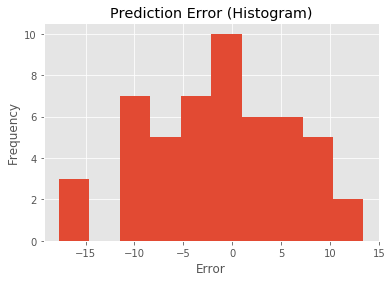

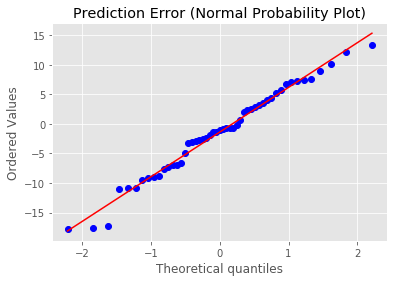

done


In [9]:
print('starting')

# This represents the expected rate at which the interpolator correctly predicts the outcome of the race
print('\n\nFraction of Races Predicted Correctly: ' + str(np.sum(correct) / len(correct)))
print('Mean Squared Prediction Error: ' + str(np.mean(er ** 2)))
print('Mean Absolute Prediction Error: ' + str(np.mean(np.abs(er))))
print('Mean Prediction Error: ' + str(np.mean(er)))
print('Stdev Prediction Error: ' + str(np.std(er)))

plt.hist(er)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Prediction Error (Histogram)')
plt.show()

res = stats.probplot(er, plot=plt)
plt.title('Prediction Error (Normal Probability Plot)')
plt.show()

print('done')

# Final Answer

We now plug in all available data to an interpolator and interpolate all rows. Keep in mind we expect our interpolation error to be drawn from the distribution shown above.

In [ ]:
rbfi = gen_interpolator(df, ins, outs)

tidx = range(len(raw))
trows = [raw.iloc[idx] for idx in tidx]
y_pred = [float(rbfi(*[row[rep] for rep in ins])) for row in trows]
print(y_pred)
np.savetxt('out.csv', (50 + np.array(y_pred)) / 100, delimiter=',')